In [1]:
import tensorflow as tf
import os
from glob import glob
import random
import numpy as np
 
from tqdm import tqdm 

import cv2

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU

In [2]:
input_shape = (128,128,1)

In [3]:

def read_resize_images(folder_path, new_shape = input_shape[:-1]):
    image = []
    files = os.listdir(folder_path)

    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    for filename in files:
        img = cv2.imread(os.path.join(folder_path,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, new_shape)
            image.append(img)
    return image

In [4]:
#Brain No Tumor Train Dataset
train_brain_no_tumor_folder_path = '/kaggle/input/multi-cancer/Dataset/Brain scans/No tumor/Train'
train_brain_no_tumor_images = read_resize_images(train_brain_no_tumor_folder_path)
train_brain_no_tumor_df = np.array(train_brain_no_tumor_images)
#Brain No Tumor Test Dataset
test_brain_no_tumor_folder_path = '/kaggle/input/multi-cancer/Dataset/Brain scans/No tumor/Test'
test_brain_no_tumor_images = read_resize_images(test_brain_no_tumor_folder_path)
test_brain_no_tumor_df = np.array(test_brain_no_tumor_images)
#Brain Tumor Train Dataset
train_brain_tumor_folder_path = '/kaggle/input/multi-cancer/Dataset/Brain scans/Tumor/TRAIN'
train_brain_tumor_images = read_resize_images(train_brain_tumor_folder_path)
train_brain_tumor_df = np.array(train_brain_tumor_images)
#Brain Tumor Train Masks Dataset
train_masks_brain_tumor_folder_path = '/kaggle/input/multi-cancer/Dataset/Brain scans/Tumor/TRAIN_masks'
train_masks_brain_tumor_images = read_resize_images(train_masks_brain_tumor_folder_path)
train_masks_brain_tumor_df = np.array(train_masks_brain_tumor_images)
#Brain Tumor Test Dataset
test_brain_tumor_folder_path = '/kaggle/input/multi-cancer/Dataset/Brain scans/Tumor/TEST'
test_brain_tumor_images = read_resize_images(test_brain_tumor_folder_path)
test_brain_tumor_df = np.array(test_brain_tumor_images)
#Brain Tumor Test Masks Dataset
test_masks_brain_tumor_folder_path = '/kaggle/input/multi-cancer/Dataset/Brain scans/Tumor/TEST_masks'
test_masks_brain_tumor_images = read_resize_images(test_masks_brain_tumor_folder_path)
test_masks_brain_tumor_df = np.array(test_masks_brain_tumor_images)

In [5]:
#Normalize the data
train_brain_no_tumor_df =train_brain_no_tumor_df.astype('float32')/ 255
test_brain_no_tumor_df = test_brain_no_tumor_df.astype('float32')/255
train_brain_tumor_df= train_brain_tumor_df.astype('float32')/255
train_masks_brain_tumor_df= train_masks_brain_tumor_df.astype('float32')/255
test_brain_tumor_df= test_brain_tumor_df.astype('float32')/255
test_masks_brain_tumor_df= test_masks_brain_tumor_df.astype('float32')/255

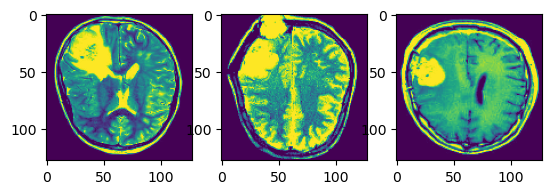

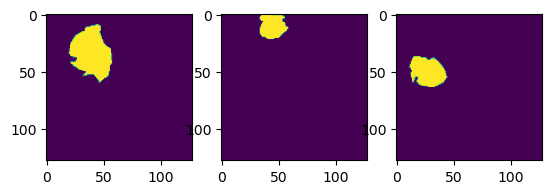

In [6]:
for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(train_brain_tumor_df[i])
plt.show()
for i in range(3):
  plt.subplot(2,3,i+1)
  plt.imshow(train_masks_brain_tumor_df[i])
plt.show()

In [7]:
#Build the model
inputs = tf.keras.layers.Input(input_shape)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])
#model.summary()

In [8]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('Brain_segmentation.h5',monitor="val_loss", verbose=2, save_best_only=True)

results = model.fit(train_brain_tumor_df,train_masks_brain_tumor_df, 
          validation_data = (test_brain_tumor_df,test_masks_brain_tumor_df),
          validation_split=0.1,
          batch_size = 16, 
          epochs = 100, 
          verbose = 2, 
          shuffle = True,
          callbacks=[checkpointer]
          )

Epoch 1/100


2023-04-17 13:46:20.556427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 0.28100, saving model to Brain_segmentation.h5
32/32 - 16s - loss: 0.4335 - accuracy: 0.8728 - IoU: 0.4750 - val_loss: 0.2810 - val_accuracy: 0.9470 - val_IoU: 0.4751 - 16s/epoch - 507ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.28100 to 0.17004, saving model to Brain_segmentation.h5
32/32 - 1s - loss: 0.1916 - accuracy: 0.9465 - IoU: 0.4750 - val_loss: 0.1700 - val_accuracy: 0.9470 - val_IoU: 0.4751 - 1s/epoch - 36ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.17004
32/32 - 1s - loss: 0.1632 - accuracy: 0.9465 - IoU: 0.4750 - val_loss: 0.1997 - val_accuracy: 0.9470 - val_IoU: 0.4751 - 1s/epoch - 31ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.17004 to 0.15696, saving model to Brain_segmentation.h5
32/32 - 1s - loss: 0.1502 - accuracy: 0.9465 - IoU: 0.4750 - val_loss: 0.1570 - val_accuracy: 0.9470 - val_IoU: 0.4751 - 1s/epoch - 36ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.15696
32/32 - 1s - los

4/4 [==============================] - 1s 8ms/step


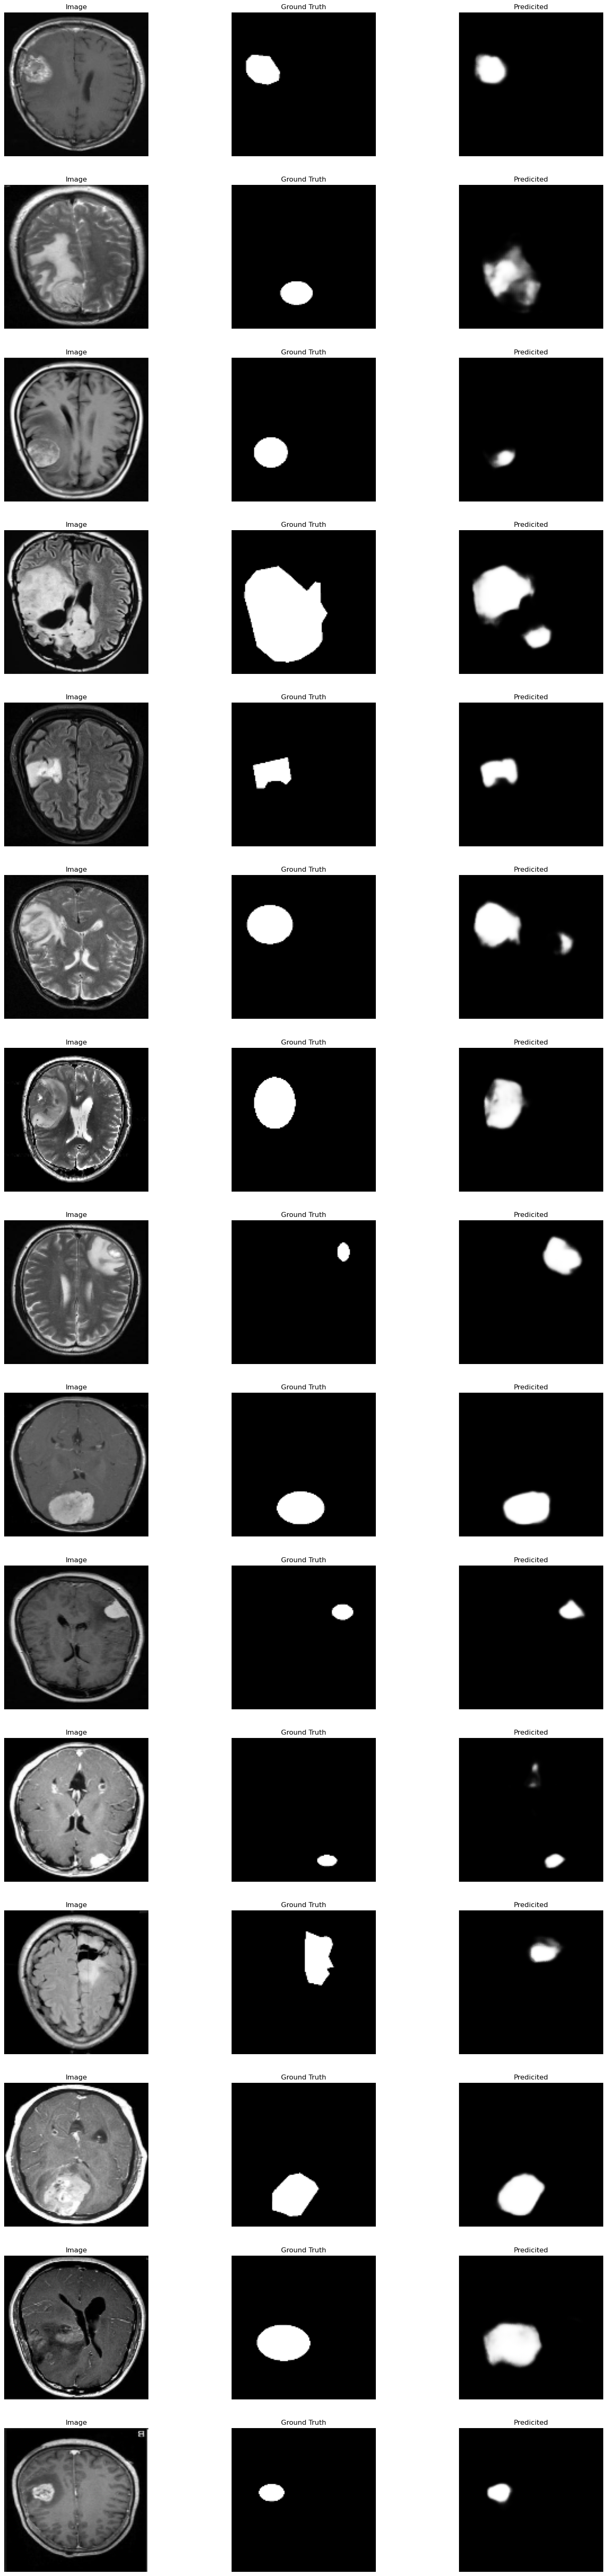

In [9]:
preds_test = model.predict(test_brain_tumor_df)
plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(np.squeeze(test_brain_tumor_df[x]), 'gray')
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(np.squeeze(test_masks_brain_tumor_df[x]), 'gray')
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(np.squeeze(preds_test[x]), 'gray')
    plt.title('Predicited')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()